In [23]:
import cv2
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pickle
import random
import scipy.spatial
import os
import matplotlib.pyplot as plt

In [7]:
# Feature extractor
def extract_features(image_path, vector_size=32):
    image = plt.imread(image_path)
    try:
        # Using KAZE, cause SIFT, ORB and other was moved to additional module
        # which is adding addtional pain during install
        alg = cv2.KAZE_create()
        # Dinding image keypoints
        kps = alg.detect(image)
        # Getting first 32 of them. 
        # Number of keypoints is varies depend on image size and color pallet
        # Sorting them based on keypoint response value(bigger is better)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        # computing descriptors vector
        kps, dsc = alg.compute(image, kps)
        # Flatten all of them in one big vector - our feature vector
        dsc = dsc.flatten()
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if dsc.size < needed_size:
            # if we have less the 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
    except cv2.error as e:
        print ('Error: ', e)
        return None

    return dsc

In [10]:
images_path = "datasets\\raw_data\\train\\0\\09ed156ffac3e70c.jpg"

In [11]:

features = extract_features(images_path)

In [12]:
features

array([-0.02360383,  0.04631179,  0.08075734, ..., -0.00027831,
        0.00043224,  0.00100091], dtype=float32)

In [17]:

def batch_extractor(images_path, pickled_db_path="features.pck"):
    files = [os.path.join(images_path, p) for p in sorted(os.listdir(images_path))]
    
    result = {}
    for f in files:
        print ('Extracting features from image %s' % f)
        name = f.split('/')[-1].lower()
        result[name] = extract_features(f)
    print (result)
    # saving all our feature vectors in pickled file
    with open(pickled_db_path, 'wb') as fp:
        pickle.dump(result, fp)
batch_extractor("datasets\\raw_data\\train\\0\\")

Extracting features from image datasets\raw_data\train\0\0052fab157ef0378.jpg
Extracting features from image datasets\raw_data\train\0\09ed156ffac3e70c.jpg
Extracting features from image datasets\raw_data\train\0\0a9bd6a52069691b.jpg
Extracting features from image datasets\raw_data\train\0\0ddc92c6353c019a.jpg
Extracting features from image datasets\raw_data\train\0\26e829f30f657d0c.jpg
Extracting features from image datasets\raw_data\train\0\2c8acb7c9958da08.jpg
Extracting features from image datasets\raw_data\train\0\4a454571caa80175.jpg
Extracting features from image datasets\raw_data\train\0\4e7c3c4e083ee269.jpg
Extracting features from image datasets\raw_data\train\0\5609f0974fa920a1.jpg
Extracting features from image datasets\raw_data\train\0\5cfe325fe4b4e2de.jpg
Extracting features from image datasets\raw_data\train\0\62b7acc90ded9ce5.jpg
Extracting features from image datasets\raw_data\train\0\634f1048ac391b9e.jpg
Extracting features from image datasets\raw_data\train\0\71acd23

In [24]:
class Matcher(object):

    def __init__(self, pickled_db_path="features.pck"):
        with open(pickled_db_path, 'rb') as fp:
            self.data = pickle.load(fp)
        self.names = []
        self.matrix = []
        for k, v in self.data.items():
            self.names.append(k)
            self.matrix.append(v)
        self.matrix = np.array(self.matrix)
        self.names = np.array(self.names)

    def cos_cdist(self, vector):
        # getting cosine distance between search image and images database
        v = vector.reshape(1, -1)
        return scipy.spatial.distance.cdist(self.matrix, v, 'cosine').reshape(-1)

    def match(self, image_path, topn=5):
        features = extract_features(image_path)
        img_distances = self.cos_cdist(features)
        # getting top 5 records
        nearest_ids = np.argsort(img_distances)[:topn].tolist()
        nearest_img_paths = self.names[nearest_ids].tolist()

        return nearest_img_paths, img_distances[nearest_ids].tolist()

In [25]:
ma = Matcher('features.pck')

In [32]:
def show_img(path):
    img = plt.imread(path)
    plt.imshow(img)
    plt.show()

In [33]:
names, match = ma.match(images_path, topn=3)
names, match

(['datasets\\raw_data\\train\\0\\09ed156ffac3e70c.jpg',
  'datasets\\raw_data\\train\\0\\9e3d408b4c02abaf.jpg',
  'datasets\\raw_data\\train\\0\\85088f9acf8d13bc.jpg'],
 [0.0, 0.28536616758952993, 0.32058543368181347])

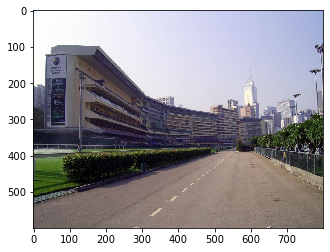

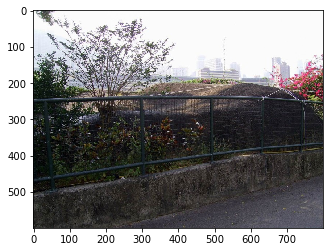

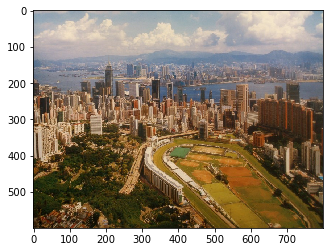

In [34]:
for paths in names:
    show_img(paths)